In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicyDemoAdaptiveAlpha, PolicySimulator, createEnv
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


(100, 4)
(100, 4)


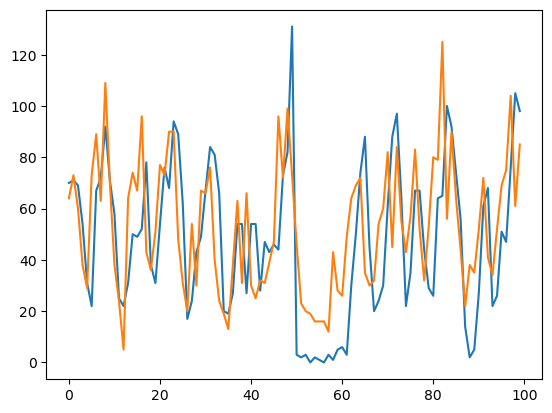

In [3]:
env.reset()
env.selectMode(mode="test", type="data")
u_record = []
u_predicted_record = []
for _ in range(100):
    env.updateStates()
    u, u_predicted = env.getStates()
    u_record.append(u)
    u_predicted_record.append(u_predicted)

u_record = np.array(u_record)
u_predicted_record = np.array(u_predicted_record)
print(u_record.shape)
print(u_predicted_record.shape)
plt.plot(u_record[:,0].flatten())
plt.plot(u_predicted_record[:,0].flatten())
plt.show()

Simulation Progress: 100%|██████████| 2000/2000 [00:06<00:00, 329.50it/s, avg reward=0.013772]


avg_reward_mdpDeter: 0.004167833470545096
avg_reward_mdpStoch: 0.004706316511334262
avg_reward_adaptive: 0.013772017812664466


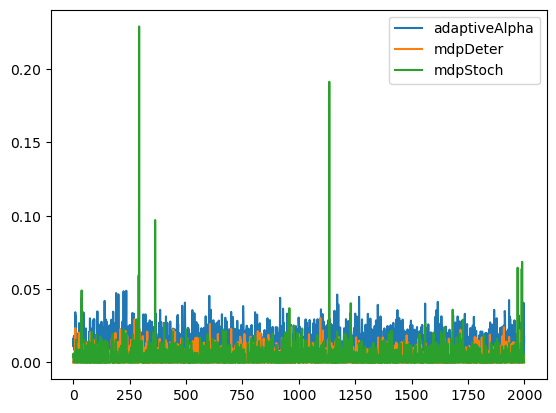

In [7]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyDeter = MdpKernel()
mdpPolicyDeter.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
mdpPolicyStoch = MdpKernel()
mdpPolicyStoch.load_policy(mdpKernelParams, policyMode="deterministic", randomR=True)
adaptiveAlphaPolicy = PolicyDemoAdaptiveAlpha(envParams)

# ==== Prepare Simulator====
num_windows = 2000
obvMode = "predicted" # "perfect" or "predicted"
policySimulator = PolicySimulator(mdpPolicyDeter, env)
simResultMdpDeter = policySimulator.runSimulation(mdpPolicyDeter, num_windows=num_windows, obvMode=obvMode, mode="test", type="data")
simResultMdpStoch = policySimulator.runSimulation(mdpPolicyStoch, num_windows=num_windows, obvMode=obvMode, mode="test", type="data")
simResultAdaptive = policySimulator.runSimulation(adaptiveAlphaPolicy, num_windows=num_windows, obvMode=obvMode, mode="test", type="data")

print(f"avg_reward_mdpDeter: {np.mean(simResultMdpDeter['rewardRecord'])}\n" + 
      f"avg_reward_mdpStoch: {np.mean(simResultMdpStoch['rewardRecord'])}\n" + 
      f"avg_reward_adaptive: {np.mean(simResultAdaptive['rewardRecord'])}")

plt.plot(simResultAdaptive['rewardRecord'], label="adaptiveAlpha")
plt.plot(simResultMdpDeter['rewardRecord'], label="mdpDeter")
plt.plot(simResultMdpStoch['rewardRecord'], label="mdpStoch")
plt.legend()
plt.show()

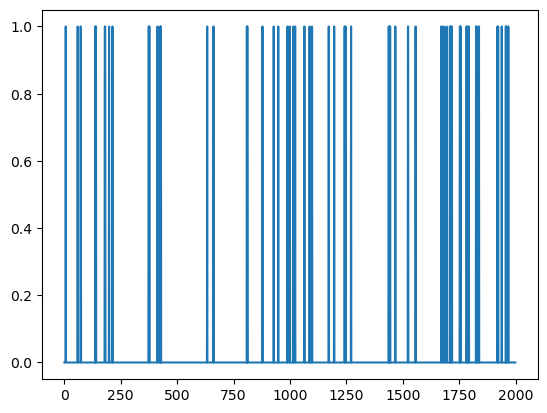

In [5]:
def _preprocess_reward(actions, bandwidth):
    # actions: list of tuples (w, r, M, alpha)
    # Each w, r is a vector (per user), alpha is scalar
    w_list, r_list, _, alpha_list = zip(*actions)
    w_arr = np.stack(w_list)  # shape: (N, N_user)
    r_arr = np.stack(r_list)  # shape: (N, N_user)
    alpha_arr = np.array(alpha_list)  # shape: (N,)
    # Compute cost per sample
    cost = np.sum(w_arr * r_arr, axis=1)  # shape: (N,)
    excess = cost - alpha_arr * bandwidth
    penalty = excess > 0
    return penalty

actions = simResultMdpDeter['actionsRecord']
bandwidth = envParams['B']

plt.plot(_preprocess_reward(actions, bandwidth))
plt.show()